# Ship Detection from Satellite Images

## Context

The working dataset is provided on Kaggle: (https://www.kaggle.com/rhammell/ships-in-satellite-imagery)
According to the dataset author: 

*Satellite imagery provides unique insights into various markets, including agriculture, defense and intelligence, energy, and finance. New commercial imagery providers, such as Planet, are using constellations of small satellites to capture images of the entire Earth every day.*

*The dataset consists of image chips extracted from Planet satellite imagery collected over the San Francisco Bay and San Pedro Bay areas of California. It includes 4000 80x80 RGB images labeled with either a "ship" or "no-ship" classification. Image chips were derived from PlanetScope full-frame visual scene products, which are orthorectified to a 3 meter pixel size.*

## Objective
The objective is to detect ships from satellite images with accuracy > 98%. In particular, to build a deep learning neural network that is able to classify satellite martime images over the californian coast as either containing ship(s) or no-ship(s).

## Data Preparation

In [74]:
# Import the needed packages
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [75]:
# Specify the data directory
data_dir = '/Users/patrickfleith/Desktop/2_DataScience /Projects/SDS/Planet/dataset'

# list all data in a list
os.chdir(data_dir)
data_list = os.listdir() # list of all images available for train/dev/test

In [76]:
# Get the length of data
print("length of dataset:",len(data_list))
M = len(data_list) # number of images available

length of dataset: 4000


let's explore what the images looks like, drawing a few pictures at random. Only those containing the whole ship are actually labelled with "ship". In many "no-ship" images, we can see only a fraction of a ship, or no ship at all: in that case, we mainly see sea water, coastal terrain, or cloud cover.

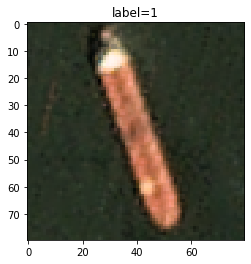

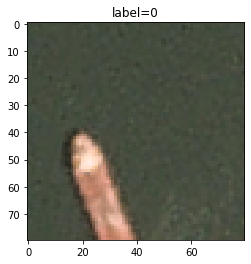

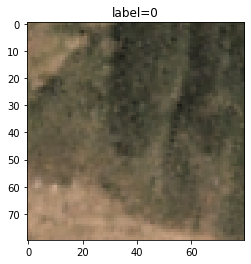

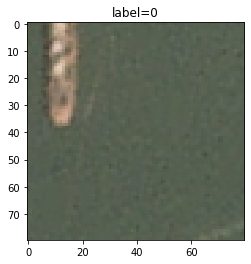

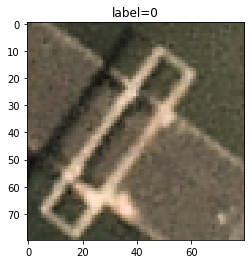

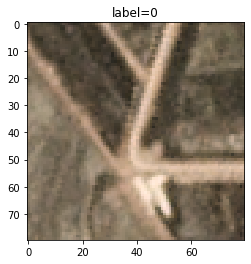

In [77]:
# pic 6 random images
rand_img_idx = np.random.randint(M, size=(6,))
for i in rand_img_idx:
    img = plt.imread(data_list[i])
    plt.imshow(img)
    plt.title("label="+data_list[i][0])
    plt.show()

Initially, all negative examples are at the beginning of the image folder while the positive images (those with ships) are stacked at the end of the folder. Therefore, to split the image dataset into a train, development, and test sets, we shuffle the images in order to get homogeneous distribution.

In [78]:
# shuffle the list
np.random.seed(5) # set the seed at 5
np.random.shuffle(data_list) # shuffle the list of image filenames

In [79]:
# Derive the Y vector associated to that shuffled list
y = np.zeros((M,1)) # pre-allocation of 1 label per image

# The first character of the file name of each image correspond to its 
# label, and therefore we extract it for each image, and convert to integer.
for i in range(M):
    y[i,0]=int(data_list[i][0])

There 4000 images in total. We keep 10% of the image files for testing, the remaining will be used as training/development sets. As the list of image filenames has been suffled, we cut the "data_list" list object 90%/10% and verify the class imbalance. 

In [80]:
# We set appart the data for train/validation from test
x_train_list = data_list[:3600] # image filenames for training/Dev
x_test_list = data_list[3600:] # image filenames for testing
y_train = y[:3600] # correponding labels for training/dev
y_test = y[3600:] # corresponding labels for testing

# Count the fraction of 0/1 in train-val vs test set
print("Fraction of ship in train/Val set:",\
      round(100*y_train.sum()/len(y_train),1),"%")

print("Fraction of ship in test      set:",\
      round(100*y_test.sum()/len(y_test),1),"%")

Fraction of ship in train/Val set: 25.0 %
Fraction of ship in test      set: 25.0 %


In general, there are 75% of images without ships, and 25% with ship. This is known as the the class imbalance problem. It can be solved by adjusting the cost function with different weights per class. However, this imbalance seems acceptable, and we will first build a NN without custom wieght function, and refine it if deemed necessary.

## Data Pre-processing

In this section we stack all image pixel values into X_train and X_test numpy array. Indeed, for this particular dataset, we are using at most in the tain/dev set 3600 images of size 80x80x3. This is an image dataset of realitvely low size since it can be converted into a numpy 4D-arry of size 3600 x 80 x 80 x 3 (70 milion elements). This does not pose any memory issue for modern laptop.

In [81]:
### Pre-Processing

# Pre-allocation
X_train = np.zeros((len(x_train_list),80,80,3))
X_test = np.zeros((len(x_test_list),80,80,3))

# Load from tf.kears utils functions
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Training & Validation set
for i in tqdm(range(len(x_train_list))): # for all image filename \
    # in train/dev set
    
    # construct the full image path
    img_path = "/Users/patrickfleith/Desktop/2_DataScience /Projects/SDS/Planet/dataset/"\
        + x_train_list[i]
    
    # load the image with load_img function
    loaded_img = load_img(img_path, grayscale=False,\
                color_mode="rgb", target_size=(80,80),\
                interpolation="nearest")
        
    # convert to 3d-array  
    input_array = img_to_array(loaded_img)
    
    # Add to the train set
    X_train[i,:,:,:] = input_array

for i in tqdm(range(len(x_test_list))):
    
    # Repeat same procedure but with test images only
    img_path = "/Users/patrickfleith/Desktop/2_DataScience /Projects/SDS/Planet/dataset/"\
        + x_test_list[i]
    
    # load the image
    loaded_img = load_img(img_path, grayscale=False,\
                color_mode="rgb", target_size=(80,80),\
                interpolation="nearest")
        
    # convert to array  
    input_array = img_to_array(loaded_img)
    
    # Add to the train set
    X_test[i,:,:,:] = input_array

100%|██████████| 400/400 [00:01<00:00, 233.04it/s]


In [82]:
# have a look a the first image array
print(X_train[0])

[[[66. 75. 70.]
  [63. 76. 69.]
  [63. 78. 68.]
  ...
  [65. 76. 69.]
  [67. 78. 69.]
  [69. 79. 71.]]

 [[74. 83. 78.]
  [63. 76. 69.]
  [56. 73. 63.]
  ...
  [63. 74. 66.]
  [63. 75. 66.]
  [65. 76. 69.]]

 [[66. 79. 73.]
  [67. 80. 70.]
  [70. 83. 71.]
  ...
  [68. 79. 71.]
  [71. 82. 74.]
  [66. 77. 70.]]

 ...

 [[68. 74. 68.]
  [73. 82. 75.]
  [75. 83. 74.]
  ...
  [66. 79. 71.]
  [66. 79. 71.]
  [65. 79. 71.]]

 [[59. 67. 62.]
  [75. 83. 76.]
  [74. 81. 72.]
  ...
  [66. 78. 70.]
  [65. 78. 71.]
  [65. 79. 71.]]

 [[65. 71. 66.]
  [74. 81. 74.]
  [70. 76. 67.]
  ...
  [65. 78. 70.]
  [63. 77. 69.]
  [63. 77. 69.]]]


As we can see, the image pixel values are all, as expected, within the range of 0 - 255. To improve the learning performance of the deep neural network, it is important to feed it with normalised data. This can be done easily with the "Rescaling" function from keras preprocessing module.

The rescaling function is applied to both the train/Dev and test sets and the numpy arrays are then converted to tensors with tf.convert_to_tensor() function.

In [83]:
### Normalisation

from tensorflow.keras.layers.experimental.preprocessing import Rescaling

scaler = Rescaling(scale=1.0 / 255, dtype = 'float64')
X_train = scaler(X_train)
X_test = scaler(X_test)

# convert arrays into tensors
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

## Building the Neural Network
We are building a convolutional neural network (CNN) with Keras. Its architecture is inspired by the VGG-16 network although it differs in depth and number of Convolutional layers.
<img src="dnn_architecture.png">
A Sequential model object is used and the architecture of the CNN is the following:
- **INPUT layer:** Batches of **80x80x3** RGB images
- **CONV2D - 16 filters**, of size 3, stride 1, and same padding.
- **MAXPOOL2D** (2x2, stride of 2, and valid padding)
- **CONV2D - 32 filters**, of size 3, stride 1, and same padding.
- **MAXPOOL2D** (2x2, stride of 2, and valid padding)
- **CONV2D - 64 filters**, of size 3, stride 1, and same padding.
- **MAXPOOL2D** (2x2, stride of 2, and valid padding)
- **CONV2D - 128 filters**, of size 3, stride 1, and same padding.
- **MAXPOOL2D** (2x2, stride of 2, and valid padding)
- **Fully Connected - 1024 units**, with rectified linear activation)
- **Flatten layer** (turn the volums into a 1d array)
- **Fully Connected** layer with **1 output unit**, with sigmoid activation function.

In [84]:
####### Modelling ###########
from tensorflow.keras import layers

# Declare model and input size
model = keras.Sequential()
model.add( keras.Input(shape=(80, 80, 3)))

# Add NN layers
model.add( layers.Conv2D(16, 3, (1,1), padding="same"))
model.add( layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add( layers.Conv2D(32, 3, (1,1), padding="same"))
model.add( layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add( layers.Conv2D(64, 3, (1,1), padding="same"))
model.add( layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add( layers.Conv2D(128, 3, (1,1), padding="same"))
model.add( layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add( layers.Dense(1024, activation="relu") )
model.add( layers.Flatten())
model.add( layers.Dense(1, activation = "sigmoid"))


model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 80, 80, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 40, 40, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 128)      

## Training

The CNN model is only about 250k trainable parameters which should be reasonably fast. The aim is to test this CNN architecture and adjust hyperparameters if deemed necessary based on the performanced obtained on the developement set.

Initially, we choose the following training parameters:
- batch size of 32 images
- 20 epochs
- 20% of the train set images are used for the validation
- Adam optimizer with default learning rate se to 0.001.

We are recording the model performances on the training and validation sets during training (over 20 epochs) into an history object when calling model.fit. This will allows us to plot the learning cuvres.



======= STARTING TRAINING ===========
Epoch 1/20
90/90 [==============================] - 26s 294ms/step - loss: 0.3140 - accuracy: 0.8694 - val_loss: 0.1694 - val_accuracy: 0.9236
Epoch 2/20
90/90 [==============================] - 26s 288ms/step - loss: 0.1666 - accuracy: 0.9368 - val_loss: 0.1046 - val_accuracy: 0.9528
Epoch 3/20
90/90 [==============================] - 31s 342ms/step - loss: 0.1105 - accuracy: 0.9615 - val_loss: 0.1347 - val_accuracy: 0.9361
Epoch 4/20
90/90 [==============================] - 29s 322ms/step - loss: 0.0906 - accuracy: 0.9691 - val_loss: 0.1004 - val_accuracy: 0.9736
Epoch 5/20
90/90 [==============================] - 36s 397ms/step - loss: 0.0753 - accuracy: 0.9740 - val_loss: 0.0471 - val_accuracy: 0.9903
Epoch 6/20
90/90 [==============================] - 31s 348ms/step - loss: 0.0382 - accuracy: 0.9878 - val_loss: 0.0258 - val_accuracy: 0.9903
Epoch 7/20
90/90 [==============================] - 26s 291ms/step - loss: 0.0234 - accuracy: 0.9913 -

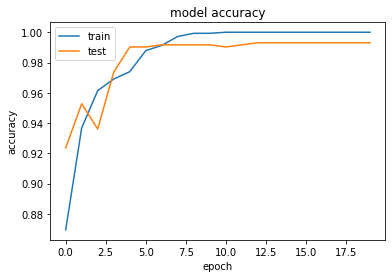

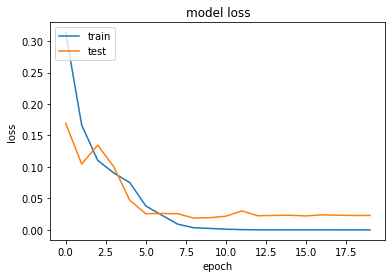

In [85]:
print("\n")
print("======= STARTING TRAINING ===========")
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    validation_split=0.2)

import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The model has finished training.
We can see the the training accuracy reached 100% accuracy on the train set within 20 epochs, and more than 99.31% on the validation set.
Due to the 100% accuracy obtained on the train set, we could tell that the model is in overfitting. However, the model seems to generalize well on the validation set to reach accruacy level above the initial objective (>98%).

Thus, we can evaluate the model performances on the test set. In addition to the model accuracy, we use typical classification metrics such as precision, recall, and f1-score.

In [86]:
# Make prediction on the test set usin the trained model
y_pred = model.predict(X_test, batch_size=32, verbose=1)
# If the probability outputed by the model is greater than 0.5,\
# we predict 1 (there is a whole ship), otherwise we predict 0 (no-ship)
y_pred = 1*(y_pred>0.5)

# print(classification_report(y_batch, y_pred))   
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
print("F1-score:",f1_score(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))

13/13 [==============================] - 1s 77ms/step
F1-score: 0.9801980198019802
Accuracy: 0.99
Precision: 0.9705882352941176
Recall: 0.99


## Conclusion
- The test accuracy is 0.99 which outperforms the project objectives.
- Precision is 0.97, recall reaches 0.99, and therefore f1-score exceeds 0.98 which.
- We can conclude that the convolutional neural network model that we have trained is able to generalise well, and reach the target level of performances.

## Futur Work

The CNN built in this project is only able to detect if the picture contains an entire ship or not. This application is restrictive, for the following reasons:
- the model makes binary classifications: there is a ship or not (does not account for partial presence of a ship, or multiple ships)
- the model does not tells where is the ship: to solve this issue, an algorithm for object detection & localisation should be developped (Yolo-like). But prior to that work, the 4000 images should be labeld with bounding boxes.
- the model does not see which pixel belong to a ship or not: for that, image segmentation, with U-net could be put in place, but again, this would require expert to manually segment each image pixel (with a numerical paint brush for example).

However, this model could serve as a basis for a simple ship dection system. Indeed, despite the above-mentioned limits, a variable-size window patch could be slided through an input high-resolution image containing no ship, one ship or multiple ships. When the sliding window size contains an entire ship, we could attribute the ship location at the center location of this sliding patch, thus providing (x,y) coordinates on the bigger picture. This would allow to detect multiple ships in inputed image, without the need to manually label an entire new set of pictures. However, this technics would be slow to run predictions and will likely reach only moderate performance as compare to the potential of Yolo-like algorithms.